In [1]:
from tinkoff.invest import Client
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [42]:
def money(v):
    return v.units + v.nano / 1e9

In [43]:
#Информация о инструменте и лотность
def info_instrument(instrument):
    name = []
    figi = []
    ticker = []
    lot = []
    currency = []
    country = []
    sector = []
    nominal = []
    
    lots = {}
    
    for i in instrument:
        lots[i.figi] = i.lot
        figi.append(i.figi)
        name.append(i.name)
        ticker.append(i.ticker)
        lot.append(i.lot)
        currency.append(i.currency)
        country.append(i.country_of_risk_name)
        try:
            nominal.append(money(i.nominal))
        except AttributeError:
            nominal.append(None)
        try:
            sector.append(i.sector)
        except AttributeError:
            sector.append(None)
    
    list_info = [name, figi, ticker, lot, currency, country, sector, nominal]
    list_info_name = ['name', 'figi', 'ticker', 'lot', 'currency', 'country', 'sector', 'nominal']
    dict_info = {}
    
    for i in range(8):
        dict_info[list_info_name[i]] = list_info[i]
            
    return dict_info, lots

**Файл с токеном**

In [2]:
token = open('Проект 1.txt', 'r').read()

In [51]:
accounts_id = []
accounts_name = []
accounts_opened = []

with Client(token) as client:
    
    #Информация о брокерских счетах
    accounts = client.users.get_accounts()
    for account in accounts.accounts:
        accounts_id.append(account.id)
        accounts_name.append(account.name)
        accounts_opened.append(account.opened_date.date())
        
    #Информация о всех инструментах
    info_shares = info_instrument(client.instruments.shares().instruments)[0]
    info_bonds = info_instrument(client.instruments.bonds().instruments)[0]
    info_etfs = info_instrument(client.instruments.etfs().instruments)[0]
    info_currencies = info_instrument(client.instruments.currencies().instruments)[0]
    
    #Лотность инструмента
    lots_info_shares = info_instrument(client.instruments.shares().instruments)[1]
    lots_info_bonds = info_instrument(client.instruments.bonds().instruments)[1]
    lots_info_etfs = info_instrument(client.instruments.etfs().instruments)[1]
    lots_info_currencies = info_instrument(client.instruments.currencies().instruments)[1]
    
#Лотность всех инструментов    
all_lots_info = {**lots_info_shares, **lots_info_bonds, **lots_info_etfs, **lots_info_currencies}

#Таблицы с информацией о инстурментах
df_all_info = pd.DataFrame(info_shares).append(pd.DataFrame(info_bonds))\
                .append(pd.DataFrame(info_etfs)).append(pd.DataFrame(info_currencies))

#Таблица с информацией о счетах
accounts = pd.DataFrame({'account_id': accounts_id,
                         'account_name': accounts_name,
                         'account_opened': accounts_opened})
accounts

,account_id,account_name,account_opened
0,2059303392,казино (300к (3574)),2021-01-08
1,2082914785,ИИС РОССИЯ РОССИЯ,2021-04-29
2,2093668743,"фонды, нахуй?",2021-06-29
3,2163534858,Брокерский счёт 2,2022-03-28


In [26]:
number_account = 0

account_id = accounts.iloc[number_account][0]
start_date = datetime.datetime(accounts.iloc[number_account][2].year,
                               accounts.iloc[number_account][2].month,
                               accounts.iloc[number_account][2].day)

In [27]:
un_type = []


with Client(token) as client:
    r = client.operations.get_operations(account_id=account_id,
                                         from_=start_date,
                                         to=datetime.datetime.now()
                                        )
    for operation in r.operations:
        if operation.type not in un_type:
            un_type.append(operation.type)
un_type 

['Выплата дивидендов',
 'Удержание налога по дивидендам',
 'Удержание комиссии за операцию',
 'Покупка ЦБ',
 'Продажа ЦБ',
 'Выплата купонов',
 'Удержание налога по купонам',
 'writing_off_varmargin',
 'Удержание комиссии за обслуживание брокерского счёта',
 'Вывод денежных средств',
 'Удержание налога',
 'Завод денежных средств',
 'Корректировка налога']

In [32]:
figi_buy = []
date_buy = []
price_buy = []

figi_sold = []
date_sold = []
price_sold = []

figi_commission = []
commission = []

with Client(token) as client:
    r = client.operations.get_operations(account_id='2059303392',
                                         from_=datetime.datetime(2021,1,8),
                                         to=datetime.datetime.now()
                                        )
    for operation in r.operations:
        if operation.state == 1:
            if operation.type == 'Покупка ЦБ':
                if operation.figi not in ['BBG00VHGV1J0','', 'BBG00Y4RPMM1']:
                    for i in range(int(operation.quantity / all_lots_info[operation.figi])):
                        figi_buy.append(operation.figi)
                        date_buy.append(operation.date)
                        price_buy.append(money(operation.price) * all_lots_info[operation.figi])
                        
            elif operation.type == 'Продажа ЦБ':
                if operation.figi not in ['BBG00VHGV1J0','', 'BBG00Y4RPMM1']:
                    for i in range(int(operation.quantity / all_lots_info[operation.figi])):
                        figi_sold.append(operation.figi)
                        date_sold.append(operation.date)
                        price_sold.append(money(operation.price) * all_lots_info[operation.figi])
                        
            if operation.type == 'Удержание комиссии за операцию' :
                figi_commission.append(operation.figi)
                commission.append(money(operation.payment))

In [33]:
df_comission = pd.DataFrame({
                             'figi_commission': figi_commission,
                             'commission' : commission
                            })
df_comission = df_comission.groupby('figi_commission', as_index=False).agg({'commission': 'sum'})
df_comission

,figi_commission,commission
0,,-0.63
1,BBG000B9XRY4,-0.70
2,BBG000B9ZLB0,-0.09
3,BBG000BBJQV0,-0.09
4,BBG000BBK4B9,-0.06
...,...,...
80,BBG012F7Y8K5,-5.21
81,BBG0320C1036,-2.05
82,TCS00A102DK3,-4.85
83,TCS00A103117,-29.99


In [34]:
df_buy = pd.DataFrame({
                       'date_buy' : date_buy,
                       'figi': figi_buy,
                       'price_buy': price_buy
                        })

df_buy = df_buy.sort_values(['figi', 'date_buy']).reset_index(drop=True)

In [35]:
df_buy

,date_buy,figi,price_buy
0,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927
1,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927
2,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927
3,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927
4,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927
...,...,...,...
1390,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000
1391,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000
1392,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000
1393,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000


In [36]:
df_sold = pd.DataFrame({
                       'date_sold' : date_sold,
                       'figi': figi_sold,
                       'price_sold': price_sold
                        })

df_sold = df_sold.sort_values(['figi', 'date_sold']).reset_index(drop=True)

In [37]:
df_buy['c'] = df_buy.groupby(['figi']).cumcount()+1
df_sold['c'] = df_sold.groupby(['figi']).cumcount()+1

In [38]:
df_buy_sold = df_buy.merge(df_sold,
                           how='left',
                           on=['figi', 'c'])
df_buy_sold

,date_buy,figi,price_buy,c,date_sold,price_sold
0,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,1,2021-05-07 07:41:28.205000+00:00,5.968012
1,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,2,2021-05-07 07:41:28.205000+00:00,5.968012
2,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,3,2021-05-07 07:41:28.205000+00:00,5.968012
3,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,4,2021-05-07 07:41:28.205000+00:00,5.968012
4,2021-04-27 12:53:30.016000+00:00,BBG000000001,5.927,5,2021-05-07 07:41:28.205000+00:00,5.968012
...,...,...,...,...,...,...
1390,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,6,NaT,NaN
1391,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,7,NaT,NaN
1392,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,8,NaT,NaN
1393,2022-04-25 11:29:07.751000+00:00,TCS00A103935,846.000,9,NaT,NaN


In [39]:
df_buy_sold[df_buy_sold['figi'] == 'BBG0013HGFT4']


,date_buy,figi,price_buy,c,date_sold,price_sold


In [211]:
df_closed = df_buy_sold[~df_buy_sold['price_sold'].isna()]
df_closed = df_closed.groupby(['figi'], as_index=False).agg({'price_buy': 'sum',
                                                             'price_sold': 'sum'})
df_closed = df_closed.merge(df_all_info[['figi', 'name', 'ticker', 'country', 'sector', 'currency']],
                            how='left',
                            on='figi')
df_closed['profit'] = df_closed['price_sold'] - df_closed['price_buy']
df_closed['profit_perc'] = (df_closed['price_sold'] / df_closed['price_buy'] - 1) * 100

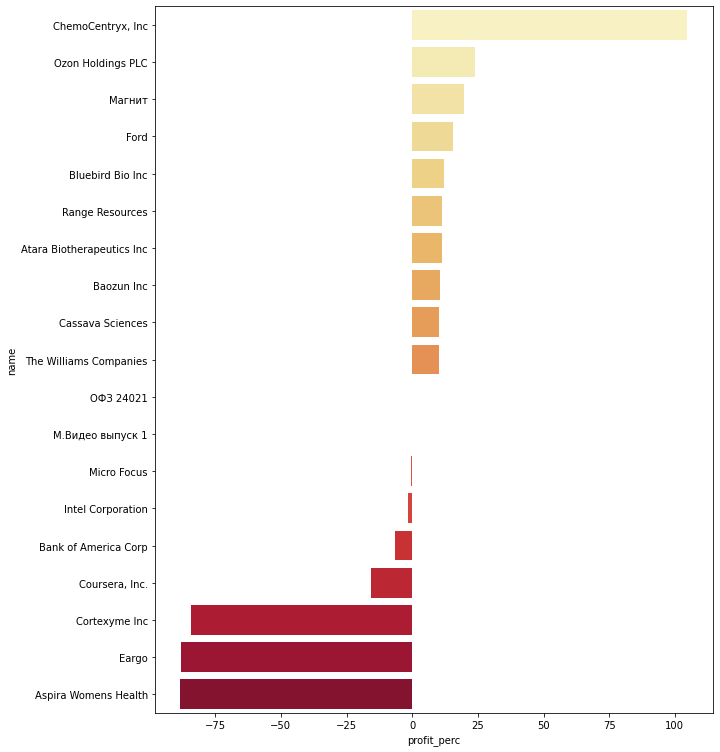

In [208]:
top = 10
for_graph_percent = df_closed[df_closed['profit_perc'] > 0].sort_values('profit_perc', ascending=False).head(top)\
                .append(df_closed[df_closed['profit_perc'] < 0].sort_values('profit_perc').head(top)).reset_index(drop=True)
for_graph_percent.sort_values('profit_perc', 
                      ascending=False, 
                      inplace=True)

plt.figure(figsize=(10, 13))
sns.barplot(y=for_graph_percent['name'], x=for_graph_percent['profit_perc'], palette="YlOrRd")

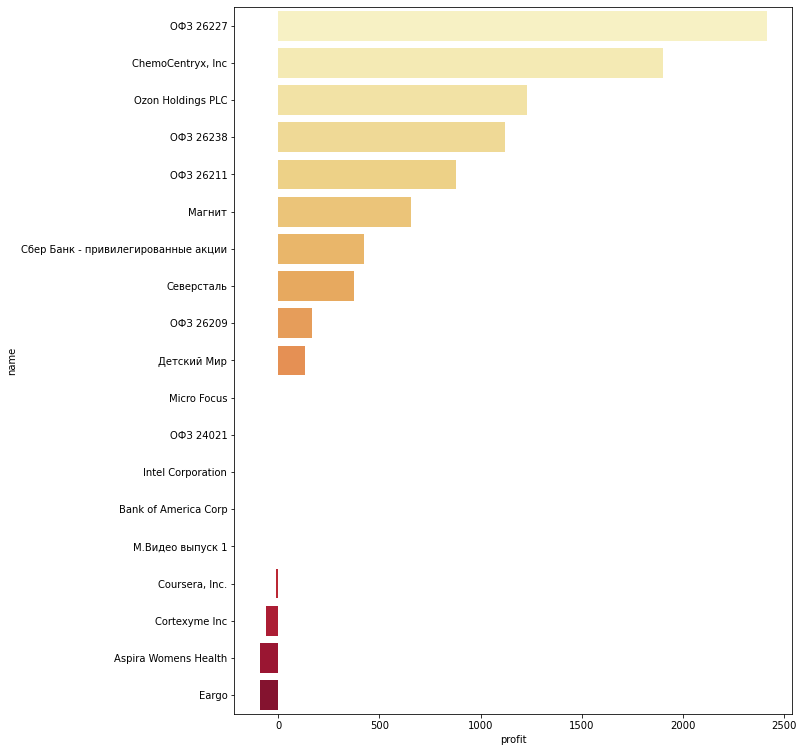

In [209]:
top = 10
for_graph_profit = df_closed[df_closed['profit'] > 0].sort_values('profit', ascending=False).head(top)\
                .append(df_closed[df_closed['profit'] < 0].sort_values('profit').head(top)).reset_index(drop=True)
for_graph_profit.sort_values('profit', 
                      ascending=False, 
                      inplace=True)

plt.figure(figsize=(10, 13))
sns.barplot(y=for_graph_profit['name'], x=for_graph_profit['profit'], palette="YlOrRd")

In [15]:
un_type = []


with Client(token) as client:
    r = client.operations.get_operations(account_id='2059303392',
                                         from_=datetime.datetime(2021,1,8),
                                         to=datetime.datetime.now()
                                        )
    for operation in r.operations:
        if operation.type == 'Покупка ЦБ' :
            #print(operation.parent_operation_id)
            #print(operation.type)
            print(operation.instrument_type,'|', operation.figi,'|', operation.parent_operation_id,'|',operation.date,'|',  operation.payment,'|', operation.price,'|', operation.state,'|', operation.quantity,'|', operation.type)
    #print(r)

currency | BBG0013HGFT4 |  | 2022-05-25 08:05:22+00:00 | MoneyValue(currency='rub', units=-840, nano=-340000000) | MoneyValue(currency='rub', units=56, nano=22667000) | OperationState.OPERATION_STATE_EXECUTED | 15 | Покупка ЦБ
share | BBG002B04MT8 |  | 2022-05-16 14:24:56.938000+00:00 | MoneyValue(currency='usd', units=-72, nano=-780000000) | MoneyValue(currency='usd', units=24, nano=260000000) | OperationState.OPERATION_STATE_EXECUTED | 3 | Покупка ЦБ
currency | BBG0013HGFT4 |  | 2022-05-16 14:19:38+00:00 | MoneyValue(currency='rub', units=-3012, nano=-700000000) | MoneyValue(currency='rub', units=64, nano=100000000) | OperationState.OPERATION_STATE_EXECUTED | 47 | Покупка ЦБ
share | BBG0056JW5G6 |  | 2022-05-16 14:17:20.610000+00:00 | MoneyValue(currency='usd', units=-118, nano=-170000000) | MoneyValue(currency='usd', units=39, nano=390000000) | OperationState.OPERATION_STATE_EXECUTED | 3 | Покупка ЦБ
share | BBG000CL9VN6 |  | 2022-05-16 14:16:36.278000+00:00 | MoneyValue(currency='u

share | BBG000R7Z112 |  | 2021-10-18 11:13:51.953000+00:00 | MoneyValue(currency='usd', units=-81, nano=-760000000) | MoneyValue(currency='usd', units=40, nano=880000000) | OperationState.OPERATION_STATE_EXECUTED | 2 | Покупка ЦБ
share | BBG0320C1036 |  | 2021-10-18 11:11:17.791000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=6, nano=500000000) | OperationState.OPERATION_STATE_CANCELED | 10 | Покупка ЦБ
share | BBG005Q3MQY4 |  | 2021-10-13 21:41:11.234000+00:00 | MoneyValue(currency='usd', units=-31, nano=-340000000) | MoneyValue(currency='usd', units=15, nano=670000000) | OperationState.OPERATION_STATE_EXECUTED | 2 | Покупка ЦБ
share | BBG004MN1R41 |  | 2021-10-13 13:17:13.117000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=19, nano=800000000) | OperationState.OPERATION_STATE_CANCELED | 5 | Покупка ЦБ
share | BBG005MX5GZ2 |  | 2021-10-11 09:49:15.844000+00:00 | MoneyValue(currency='usd', units=-35, nan

share | BBG000KGYRF8 |  | 2021-06-03 10:52:02.358000+00:00 | MoneyValue(currency='usd', units=-7, nano=-310000000) | MoneyValue(currency='usd', units=7, nano=310000000) | OperationState.OPERATION_STATE_EXECUTED | 1 | Покупка ЦБ
share | BBG000KGYRF8 |  | 2021-06-03 08:40:05.451000+00:00 | MoneyValue(currency='usd', units=-14, nano=-820000000) | MoneyValue(currency='usd', units=7, nano=410000000) | OperationState.OPERATION_STATE_EXECUTED | 2 | Покупка ЦБ
share | BBG000KGYRF8 |  | 2021-06-03 08:28:51.241000+00:00 | MoneyValue(currency='usd', units=0, nano=0) | MoneyValue(currency='usd', units=7, nano=380000000) | OperationState.OPERATION_STATE_CANCELED | 2 | Покупка ЦБ
share | BBG000BCTLF6 |  | 2021-06-03 08:22:26.383000+00:00 | MoneyValue(currency='usd', units=-42, nano=-830000000) | MoneyValue(currency='usd', units=42, nano=830000000) | OperationState.OPERATION_STATE_EXECUTED | 1 | Покупка ЦБ
share | BBG000BCTLF6 |  | 2021-06-03 08:12:47.991000+00:00 | MoneyValue(currency='usd', units=0